**Goal**: compute some characteristics of the files in the datastet using static analysis.

In [1]:
import project_path
from rdlib import *  # this imports the base libraries

In [13]:
PATH_DIR_FILES = '../data/datasets/exp_v08/files_selected/'
MAGIC_STRING = 'MAGIC_STRING_LINTQ_123456'

In [3]:
import os

# List all files in the directory
list_files = os.listdir(PATH_DIR_FILES)#[:1000]
n_files = len(list_files)
print('Number of files: {}'.format(n_files))

Number of files: 7568


In [4]:
from multiprocessing import Pool
from functools import partial
from typing import List
from tqdm import tqdm
import ast

def extract_imported_classes(code: str) -> List[str]:
    """Extract all the imported classes from the python code.
    
    e.g.:
    code = '''
    import numpy as np
    import pandas as pd
    from sklearn import linear_model
    from sklearn.linear_model import LogisticRegression
    '''
    extract_imported_classes(code)
    >>> ['numpy', 'pandas', 'sklearn.linear_model', 'sklearn.linear_model.LogisticRegression']
    """
    # Parse the code
    tree = ast.parse(code)
    
    # Extract the imported classes
    imported_classes = []
    for node in ast.walk(tree):
        if isinstance(node, ast.Import):
            imported_classes += [n.name for n in node.names]
        elif isinstance(node, ast.ImportFrom):
            imported_classes.append(node.module + '.' + node.names[0].name)
    
    return imported_classes


def extract_api_calls(code: str) -> List[str]:
    """Extract all the API calls from the python code.
    
    e.g.:
    code = '''
    import numpy as np
    import pandas as pd

    X = np.array([[1, 2], [3, 4]])
    df = pd.DataFrame(X)
    '''
    extract_api_calls(code)
    >>> ['np.array', 'pd.DataFrame']
    """
    # Parse the code
    tree = ast.parse(code)
    
    # Extract the API calls
    api_calls = []
    for node in ast.walk(tree):
        if isinstance(node, ast.Call):
            api_calls.append(node.func.attr if hasattr(node.func, 'attr') else node.func.id)
    
    return api_calls


def get_register_sizes(code: str) -> List[str]:
    """Extract all the register sizes from the python code.
    
    e.g.:
    code = '''
    from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    qc = QuantumCircuit(qr, cr)
    qc2 = QuantumCircuit(10)
    '''
    get_register_sizes(code)
    >>> ['2', '2', '10']
    """
    # Parse the code
    tree = ast.parse(code)
    
    # Extract the register sizes
    register_sizes = []
    for node in ast.walk(tree):
        if isinstance(node, ast.Call) and hasattr(node.func, 'id') and node.func.id in ['QuantumRegister', 'ClassicalRegister']:
            if len(node.args) == 1 and isinstance(node.args[0], ast.Num):
                register_sizes.append(node.args[0].n)
        
        # check if the QuantumCircuit argument is a number
        if isinstance(node, ast.Call) and hasattr(node.func, 'id') and node.func.id == 'QuantumCircuit':
            if len(node.args) == 1 and isinstance(node.args[0], ast.Num):
                register_sizes.append(node.args[0].n)
    
    return register_sizes


def read_file(file_name: str, path_dir: str) -> pd.DataFrame:
    """Reads the content of a file.
    
    It returns a dataframe with columns: 'file_name', 'content'
    """
    # Read the file
    with open(os.path.join(path_dir, file_name), 'r') as file:
        content = file.read()
    global MAGIC_STRING
    try: 
        classes = extract_imported_classes(content)
    except Exception as e:
        # print('Error: {}'.format(e))
        classes = [MAGIC_STRING + str(e)]

    try:
        api_calls = extract_api_calls(content)
    except Exception as e:
        # print('Error: {}'.format(e))
        api_calls = [MAGIC_STRING + str(e)]

    try:
        register_sizes = get_register_sizes(content)
    except Exception as e:
        # print('Error: {}'.format(e))
        register_sizes = [MAGIC_STRING + str(e)]

    # Create a dataframe
    df = pd.DataFrame({
        'file_name': [file_name], 
        'content': [content],
        'classes': [classes],
        'api_calls': [api_calls],
        'register_sizes': [register_sizes]
    })
    
    return df


def read_files_in_parallel(list_files: List[str]) -> pd.DataFrame:
    """Reads the content of the files in parallel.
    
    It returns a dataframe with columns: 'file_name', 'content'
    """
    # Create a partial function with the fixed arguments
    read_file_partial = partial(read_file, path_dir=PATH_DIR_FILES)
    
    # Create a pool of workers
    pool = Pool()
    
    # Read the files in parallel
    list_df = list(tqdm(pool.imap(read_file_partial, list_files), total=len(list_files)))
    
    # Close the pool
    pool.close()
    
    # Concatenate the dataframes
    df = pd.concat(list_df, ignore_index=True)
    
    return df

In [5]:
df_all = read_files_in_parallel(list_files)

100%|██████████| 7568/7568 [00:11<00:00, 646.41it/s]


In [6]:
n_files = len(df_all)
print(f'Number of files: {n_files}')
df_all.head()

Number of files: 7568


,file_name,content,classes,api_calls,register_sizes
0,qiskit_runner_a05ff0.py,# https://github.com/zapatacomputing/orquestra...,"[typing.List, orquestra.quantum.api.BaseCircui...","[export_to_qiskit, add_register, measure, Clas...",[]
1,01_operator_flow_87f6ae.py,# https://github.com/WhenTheyCry96/qiskit_stud...,"[qiskit.opflow.I, qiskit.opflow.StateFn, math,...","[print, print, print, print, print, print, pri...",[]
2,graders_f3ed23.py,# https://github.com/QPoland/walcz-o-superpozy...,"[qiskit.QuantumCircuit, qiskit.compiler.transp...","[Unroller, PassManager, count_ops, isinstance,...",[]
3,challenge4_circuitdecomposition_6c33bd.py,# https://github.com/zehanort/IBM-Quantum-Chal...,"[may4_challenge.ex4.get_unitary, qiskit.Quantu...","[get_unitary, print, print, array, get_unitary...",[4]
4,run_circuit_3a72ed.py,# https://github.com/akashdhruv/FlowX/blob/a4a...,"[qiskit.IBMQ, qiskit.providers.ibmq.least_busy...","[measure, execute, job_monitor, result, get_co...",[]


In [7]:
# number of files with errors
for i_attribute in ['classes', 'api_calls', 'register_sizes']:
    n_errors = df_all[df_all[i_attribute].apply(lambda x: MAGIC_STRING in str(x))].shape[0]
    print(f'Number of files with errors in {i_attribute}: {n_errors}')

Number of files with errors in classes: 69
Number of files with errors in api_calls: 185
Number of files with errors in register_sizes: 21


In [8]:
# df = df_all.copy()
# # keep two lines
# df = df.head(4)

def get_dataset_level_list(df: pd.DataFrame, attribute: str) -> pd.DataFrame:
    """Explode the given attribute and return a list of all the values.
    
    Note that this will drop the element with empty lists on that attribute.
    """
    # Keep only the columns of interest
    df = df[['file_name', attribute]]
    # Explode the attribute
    df = df.explode(attribute)
    # Drop NaN values
    df = df.dropna(subset=[attribute])
    return df

df_classes = get_dataset_level_list(df_all, 'classes')
df_api_calls = get_dataset_level_list(df_all, 'api_calls')
df_register_sizes = get_dataset_level_list(df_all, 'register_sizes')

df_api_calls.head()

,file_name,api_calls
0,qiskit_runner_a05ff0.py,export_to_qiskit
0,qiskit_runner_a05ff0.py,add_register
0,qiskit_runner_a05ff0.py,measure
0,qiskit_runner_a05ff0.py,ClassicalRegister
0,qiskit_runner_a05ff0.py,isinstance


In [83]:
df_register_sizes.head()

,file_name,register_sizes
3,challenge4_circuitdecomposition_6c33bd.py,4
6,game2_ec0ca2.py,1
8,circuit_basics_49646b.py,3
9,final5_oracle_test_mymap_61e2ed.py,12
9,final5_oracle_test_mymap_61e2ed.py,12


Number of unique files with API calls containing "Gate": 574


,file_name,api_calls
6,game2_ec0ca2.py,HGate
6,game2_ec0ca2.py,passThroughHGate
6,game2_ec0ca2.py,passThroughHGate
6,game2_ec0ca2.py,passThroughHGate
6,game2_ec0ca2.py,passThroughHGate


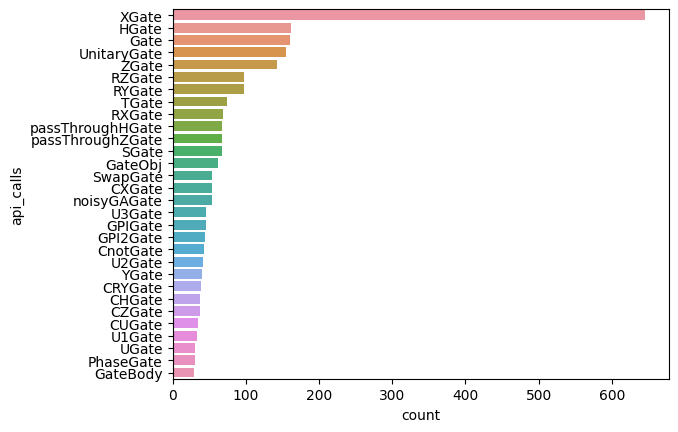

In [9]:
# filter all API calls containing "Gate"
top_k = 30

df_gate_calls = df_api_calls[df_api_calls['api_calls'].apply(lambda x: 'Gate' in x)]
n_unique_files = df_gate_calls['file_name'].nunique()
print(f'Number of unique files with API calls containing "Gate": {n_unique_files}')
sns.countplot(
    data=df_gate_calls,
    y='api_calls',
    order=df_gate_calls['api_calls'].value_counts().iloc[:top_k].index
)
df_gate_calls.head()

In [10]:
# get unique calls, remove the "Gate" part and lowecase
unique_gate_calls = df_gate_calls['api_calls'].unique()
unique_gate_calls = [i_call.replace('Gate', '').lower() for i_call in unique_gate_calls]
unique_gate_calls[:7]

['h', 'passthroughh', 'z', 'passthroughz', 'cx', 'swap', 'rzz']

Number of unique files with direct API calls: 5534


<AxesSubplot: xlabel='count', ylabel='api_calls'>

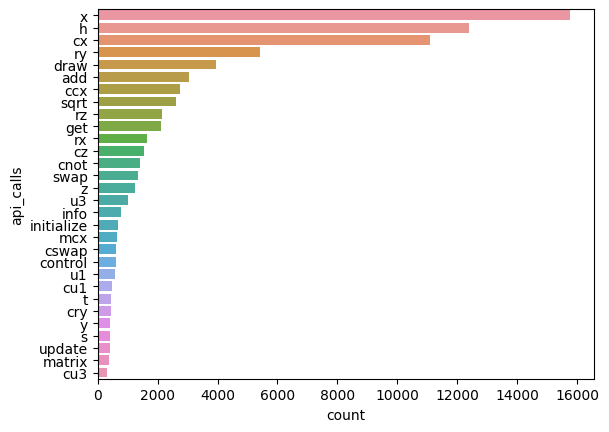

In [11]:
top_k = 30

df_direct_gate_calls = df_api_calls[df_api_calls['api_calls'].apply(lambda x: x in unique_gate_calls)]
n_unique_files = df_direct_gate_calls['file_name'].nunique()
print(f'Number of unique files with direct API calls: {n_unique_files}')
sns.countplot(
    data=df_direct_gate_calls,
    y='api_calls',
    order=df_direct_gate_calls['api_calls'].value_counts().iloc[:top_k].index
)

Number of unique classes: 7227


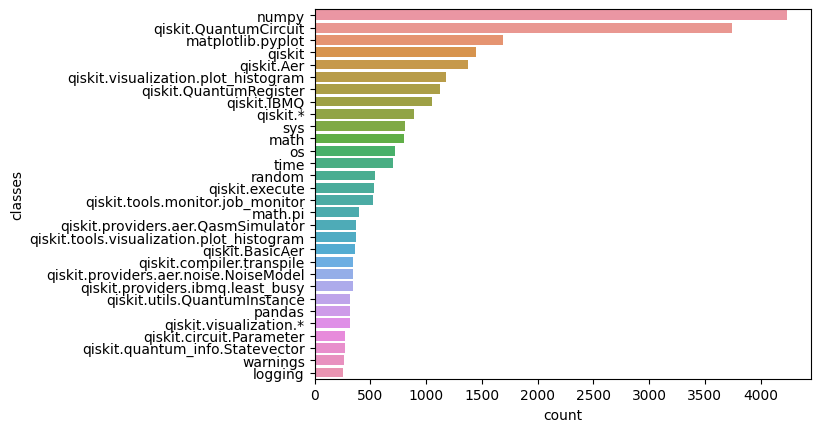

Number of unique api_calls: 19816


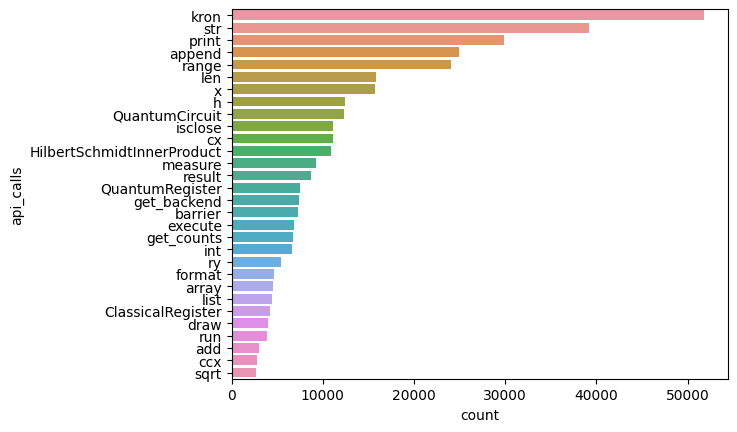

In [82]:
top_k = 30

for (i_df, i_attribute) in zip(
    [df_classes, df_api_calls],
    ['classes', 'api_calls']
):
    print(f'Number of unique {i_attribute}: {i_df[i_attribute].nunique()}')

    sns.countplot(
        data=i_df,
        y=i_attribute,
        order=i_df[i_attribute].value_counts().iloc[:top_k].index
    )
    plt.show()

In [ ]:
df = df_register_sizes.copy()

df['register_is_int'] = df['register_sizes'].apply(lambda x: isinstance(x, int))
# filter out the files with errors
df = df[df['register_is_int'] == True]

sns.histplo


In [51]:
# filter all the relevant_api_calls which contain measure
measurement_related_calls = [
    i_call for i_call in df_api_calls['api_calls'].unique()
    if 'measure' in i_call.lower()
]
measurement_related_calls

['measure',
 '_run_batch_and_measure',
 'Measurements',
 'measure_all',
 'measure_message',
 'perform_measurement',
 'remove_last_measurements',
 'Measurement',
 'run_and_measure',
 'run_batch_and_measure',
 'get_measurement_outcome_distribution',
 'MeasurementTrackingBackend',
 'MeasureCircuit',
 'qpe_measure',
 'remove_final_measurements',
 'get_measurement_qubits_from_transpiled_circuit',
 'MeasureZ',
 'obtain_measurements_linear',
 'obtain_measurements_cyclic',
 'obtain_measurements_square_lattice',
 'measures_exploitation',
 'final_measurement_mapping',
 'measure_bits',
 'Measure_PauliWord',
 'change_basis_for_Z_measure',
 'append_measurements',
 'prepare_and_measure_single_qubit_in_qiskit_quantum_register_in_z_basis',
 'prepare_and_measure_single_qubit_in_qiskit_quantum_register_in_x_basis',
 '_bell_state_measurement',
 'measure_1qubit',
 'measure_2qubit',
 'measure_xy',
 'extract_measurement_idx',
 'measure_node_to_circuit',
 '_calculate_measurements',
 'add_random_measurements'

In [65]:
# compute the number of gate api calls per file
api_calls_gate_obj = list(df_gate_calls['api_calls'].unique())
api_calls_gate_call = [
    i_call.replace('Gate', '').lower() for i_call in api_calls_gate_obj]
relevant_api_calls = api_calls_gate_call + api_calls_gate_obj
print(f'Number of relevant API calls: {len(relevant_api_calls)}')
print(f'Relevant API calls: {relevant_api_calls[:5]}')

df = df_all.copy()
# keep only the columns of interest
df = df[['file_name', 'api_calls']]
# keep on those with relevant api calls (at least one)
df['has_gate'] = df['api_calls'].apply(lambda x: any(i_call in x for i_call in relevant_api_calls))
# count the gate calls per file
df['api_calls_gate'] = df['api_calls'].apply(
    lambda x: [i_call for i_call in x if i_call in relevant_api_calls]
)
df['n_api_calls_gate'] = df['api_calls_gate'].apply(lambda x: len(x))
# count how many include measurement gate calls
# list of gate calls with measure: measurement_related_calls
df['has_measure'] = df['api_calls_gate'].apply(lambda x: any(i_call in x for i_call in measurement_related_calls))
# get the measruement calls
df['api_calls_measure'] = df['api_calls_gate'].apply(
    lambda x: [i_call for i_call in x if i_call in measurement_related_calls]
)
df['n_api_calls_measure'] = df['api_calls_measure'].apply(lambda x: len(x))

df_files_and_gate_calls = df
df_files_and_gate_calls.head()



Number of relevant API calls: 484
Relevant API calls: ['h', 'passthroughh', 'z', 'passthroughz', 'cx']


,file_name,api_calls,has_gate,api_calls_gate,n_api_calls_gate,has_measure,api_calls_measure,n_api_calls_measure
0,qiskit_runner_a05ff0.py,"[export_to_qiskit, add_register, measure, Clas...",False,[],0,False,[],0
1,01_operator_flow_87f6ae.py,"[print, print, print, print, print, print, pri...",True,"[draw, sqrt]",2,False,[],0
2,graders_f3ed23.py,"[Unroller, PassManager, count_ops, isinstance,...",False,[],0,False,[],0
3,challenge4_circuitdecomposition_6c33bd.py,"[get_unitary, print, print, array, get_unitary...",True,"[h, h, h, h]",4,False,[],0
4,run_circuit_3a72ed.py,"[measure, execute, job_monitor, result, get_co...",True,"[apply, apply]",2,False,[],0


\newcommand{\dataLintQAvgGateCallPerFile}{11}
\newcommand{\dataLintQMedianGateCallPerFile}{3}
\newcommand{\dataLintQMaxGateCallPerFile}{5010}


\newcommand{\dataLintQAvgGateCallPerFile}{11}
\newcommand{\dataLintQMedianGateCallPerFile}{3}
\newcommand{\dataLintQMaxGateCallPerFile}{5010}
Number of files with more than 50 API calls referring to Gate: 207


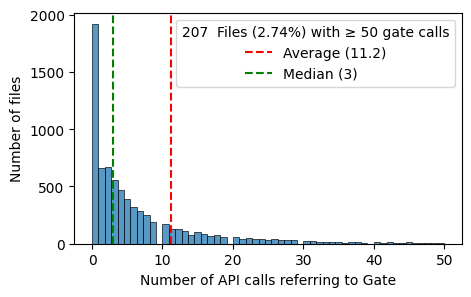

In [79]:
CAP_VALUE = 50

df = df_files_and_gate_calls


avg_api_calls_gate = df_files_and_gate_calls['n_api_calls_gate'].mean()
median_api_calls_gate = df_files_and_gate_calls['n_api_calls_gate'].median()
max_api_calls_gate = df_files_and_gate_calls['n_api_calls_gate'].max()
print("\\newcommand{\\dataLintQAvgGateCallPerFile}{" + f"{avg_api_calls_gate:.0f}" + "}")
print("\\newcommand{\\dataLintQMedianGateCallPerFile}{" + f"{median_api_calls_gate:.0f}" + "}")
print("\\newcommand{\\dataLintQMaxGateCallPerFile}{" + f"{max_api_calls_gate:.0f}" + "}")

# count the number of files with more than CAP_VALUE
n_files_with_many_calls = df[df['n_api_calls_gate'] > CAP_VALUE].shape[0]
print(f'Number of files with more than {CAP_VALUE} API calls referring to Gate: {n_files_with_many_calls}')
perc_files_with_many_calls = (n_files_with_many_calls / df.shape[0]) * 100

# filter the files with less than CAP_VALUE
df = df[df['n_api_calls_gate'] <= CAP_VALUE]

fig, ax = plt.subplots(figsize=(5, 3))
sns.histplot(
    data=df,
    x='n_api_calls_gate',
    ax=ax,
)
ax.set_xlabel('Number of API calls referring to Gate')
ax.set_ylabel('Number of files')

ax.axvline(avg_api_calls_gate, color='red', linestyle='--', label=f'Average ({avg_api_calls_gate:.1f})')
ax.axvline(median_api_calls_gate, color='green', linestyle='--', label=f'Median ({median_api_calls_gate:.0f})')

# add to the legend title
ax.legend(title=f'{n_files_with_many_calls}  Files ({perc_files_with_many_calls:.2f}%) with ≥ {CAP_VALUE} gate calls')

plt.show()

# Measurements

\newcommand{\dataLintQAvgMeasureCallPerFile}{2}
\newcommand{\dataLintQMedianMeasureCallPerFile}{0}
\newcommand{\dataLintQMaxMeasureCallPerFile}{625}
Number of files with more than 10 API calls referring to measurement: 129 (1.70%)


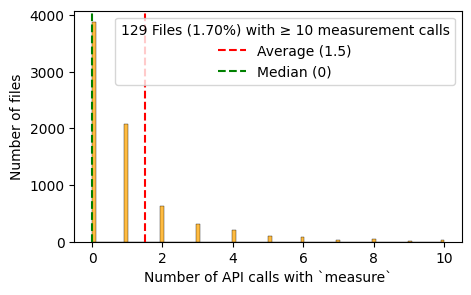

In [80]:
CAP_VALUE = 10

df = df_all.copy()
df['api_measure'] = df['api_calls'].apply(lambda x: [i_call for i_call in x if i_call in measurement_related_calls])
df['n_api_measure'] = df['api_measure'].apply(lambda x: len(x))

avg_api_calls_measure = df['n_api_measure'].mean()
median_api_calls_measure = df['n_api_measure'].median()
max_api_calls_measure = df['n_api_measure'].max()
print("\\newcommand{\\dataLintQAvgMeasureCallPerFile}{" + f"{avg_api_calls_measure:.0f}" + "}")
print("\\newcommand{\\dataLintQMedianMeasureCallPerFile}{" + f"{median_api_calls_measure:.0f}" + "}")
print("\\newcommand{\\dataLintQMaxMeasureCallPerFile}{" + f"{max_api_calls_measure:.0f}" + "}")

n_files_above_cap = df[df['n_api_measure'] > CAP_VALUE].shape[0]
perc_files_above_cap = (n_files_above_cap / df.shape[0]) * 100
print(f'Number of files with more than {CAP_VALUE} API calls referring to measurement: {n_files_above_cap} ({perc_files_above_cap:.2f}%)')

# filter out the files with more than CAP_VALUE
df = df[df['n_api_measure'] <= CAP_VALUE]

fig, ax = plt.subplots(figsize=(5, 3))
sns.histplot(
    data=df,
    x='n_api_measure',
    ax=ax,
    color='orange',
)
ax.set_ylabel('Number of files')
ax.set_xlabel('Number of API calls with `measure`')
ax.axvline(avg_api_calls_measure, color='red', linestyle='--', label=f'Average ({avg_api_calls_measure:.1f})')
ax.axvline(median_api_calls_measure, color='green', linestyle='--', label=f'Median ({median_api_calls_measure:.0f})')
ax.legend(title=f'{n_files_above_cap} Files ({perc_files_above_cap:.2f}%) with ≥ {CAP_VALUE} measurement calls')

